# LINEAR REGRESSION

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

sns.set()
pd.set_option('display.precision', 3)

Read data

In [51]:
datasetTrain = pd.read_csv('../Dades/X_train_modified.csv')
datasetTest  = pd.read_csv('../Dades/X_test_modified.csv')

columsToDrop = ['Maximum Installs', 'Price', 'Size', 'Download', 'Last Updated', 'Installs', 'LogInstalls']
categoricalColumns = ['Category', 'Free', 'Content Rating', 'Ad Supported', 'In App Purchases', 'Editors Choice']

# Convert to categorical variables
for column in categoricalColumns:
    datasetTrain[column] = datasetTrain[column].astype('category')
    datasetTest[column] = datasetTest[column].astype('category')

# Drop repeated or unwanted data (Installs is the catageorial version of "Maximum installs")
datasetTrain = datasetTrain.drop(columns=columsToDrop)
datasetTest  = datasetTest.drop(columns=columsToDrop)
    
datasetTrain.dtypes

Category              category
Rating                 float64
Free                  category
Released               float64
Content Rating        category
Ad Supported          category
In App Purchases      category
Editors Choice        category
LogMaximumInstalls     float64
LinearizedRating       float64
LinearizedPrice        float64
LogSize                float64
LogLast Updated        float64
dtype: object

Intead of ignoring categorical variables, we will do a smart trick. For each of varible, if there are $k$ categries, we will create $k$ new binary variables were the $i-th$ variable will be one iff the original variable value is the $i-th$ category

In [52]:
def convertDataSet(X, l):
    for column in l:
        Classes = X[column].unique()
        for i in Classes:
            name = column + str(i)
            X[name] = X[column]
            X[name] = np.where(X[name] == i, 1, 0)
        
        
convertDataSet(datasetTrain, categoricalColumns)
convertDataSet(datasetTest, categoricalColumns)

datasetTrain = datasetTrain.drop(columns=categoricalColumns)
datasetTest  = datasetTest.drop(columns=categoricalColumns)

datasetTrain.dtypes

Rating                   float64
Released                 float64
LogMaximumInstalls       float64
LinearizedRating         float64
LinearizedPrice          float64
                          ...   
Ad SupportedFalse          int64
In App PurchasesTrue       int64
In App PurchasesFalse      int64
Editors ChoiceFalse        int64
Editors ChoiceTrue         int64
Length: 69, dtype: object

Construct X and Y

In [53]:
Xtrain = datasetTrain.loc[:, datasetTrain.columns != 'LogMaximumInstalls']
Ytrain = datasetTrain['LogMaximumInstalls']

Xtest = datasetTest.loc[:, datasetTest.columns != 'LogMaximumInstalls']
Ytest = datasetTest['LogMaximumInstalls']

Regression

In [54]:
# We instantiate a linear regression. 
lr = LinearRegression()

# Now we train it on train data with fit method
lr.fit(Xtrain,Ytrain)

# We can predict using the predict method
Ypred = lr.predict(Xtrain)

weights = lr.coef_
intercept = lr.intercept_
# You can access to some info about the model, like the weights.
print('Coefficients: \n', weights[:10])
print('Intercept: \n', intercept)



# alternately
model = sm.OLS(Ytrain, sm.add_constant(Xtrain))
result = model.fit()
result.summary()

Coefficients: 
 [ 9.05880404e-01  3.84612767e-01 -7.49914445e-01 -3.88504902e-02
  3.52088087e-02 -2.59354483e-01  8.91817536e+09  8.91817536e+09
  8.91817536e+09  8.91817536e+09]
Intercept: 
 -104286494313.99527


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     LogMaximumInstalls   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     1798.
Date:                Sun, 02 Jun 2024   Prob (F-statistic):               0.00
Time:                        12:48:29   Log-Likelihood:            -3.0200e+05
No. Observations:              249862   AIC:                         6.041e+05
Df Residuals:                  249799   BIC:                         6.048e+05
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                           -2.135e+11   1.15e+11     -1.858      0.063   -4.39e+11    1.17e+10
Rating                              0.9058      0.011     81.923      0.000       0.884       0.927
Released                            0.3847      0.003    144.422      0.000       0.379       0.390
LinearizedRating                   -0.7499      0.007   -106.882      0.000      -0.764      -0.736
LinearizedPrice                    -0.0388      0.007     -5.901      0.000      -0.052      -0.026
LogSize                             0.0352      0.002     20.081      0.000       0.032       0.039
LogLast Updated                    -0.2594      0.002   -136.464      0.000      -0.263      -0.256
CategoryPuzzle                  -4.893e+09   2.63e+09     -1.858      0.063   -1.01e+10    2.69e+08
CategoryEducation               -4.893e+09   2.63e+09     -1.858      0.063   -1.01e+10    2.69e+08
CategoryTools                   -4.893e+09   2.63e+09     -1.858      0.063   -1.01e+10    2.69e+08
CategoryEntertainment           -4.893e+09   2.63e+09     -1.858      0.063   -1.01e+10    2.69e+08
CategoryHealth & Fitness        -4.893e+09   2.63e+09     -1.858      0.063   -1.01e+10    2.69e+08
CategoryEducational             -4.893e+09   2.63e+09     -1.858      0.063   -1.01e+10    2.69e+08
CategoryLifestyle               -4.893e+09   2.63e+09     -1.858      0.063   -1.01e+10    2.69e+08
CategoryBooks & Reference       -4.893e+09   2.63e+09     -1.858      0.063   -1.01e+10    2.69e+08
CategoryPersonalization         -4.893e+09   2.63e+09     -1.858      0.063   -1.01e+10    2.69e+08
CategoryRole Playing            -4.893e+09   2.63e+09     -1.858      0.063   -1.01e+10    2.69e+08
CategoryMusic & Audio           -4.893e+09   2.63e+09     -1.858      0.063   -1.01e+10    2.69e+08
CategoryNews & Magazines        -4.893e+09   2.63e+09     -1.858      0.063   -1.01e+10    2.69e+08
CategoryHouse & Home            -4.893e+09   2.63e+09     -1.858      0.063   -1.01e+10    2.69e+08
CategorySocial                  -4.893e+09   2.63e+09     -1.858      0.063   -1.01e+10    2.69e+08
CategoryBusiness                -4.893e+09   2.63e+09     -1.858      0.063   -1.01e+10    2.69e+08
CategoryAdventure               -4.893e+09   2.63e+09     -1.858      0.063   -1.01e+10    2.69e+08
CategoryRacing                  -4.893e+09   2.63e+09     -1.858      0.063   -1.01e+10    2.69e+08
CategoryFinance                 -4.893e+09   2.63e+09     -1.858      0.063   -1.01e+10    2.69e+08
CategoryBoard                   -4.893e+09   2.63e+09     -1.858      0.063   -1.01e+10    2.69e+08
CategorySports                  -4.893e+09   2.63e+09     -1.858      0.063   -1.01e+10    2.69e+08
CategoryShopping                -4.893e+09   2.63e+09     -1.858      0.063   -1.01

In [64]:
# We will see if we are doing better than random
Xtrain_zero = pd.DataFrame(0, index=Xtrain.index, columns=[])
model = sm.OLS(Ytrain, sm.add_constant(Xtrain_zero))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     LogMaximumInstalls   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 02 Jun 2024   Prob (F-statistic):                nan
Time:                        12:53:48   Log-Likelihood:            -3.4810e+05
No. Observations:              249862   AIC:                         6.962e+05
Df Residuals:                  249861   BIC:                         6.962e+05
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0742      0.002    -38.065      0.000      -0.078      -0.070
==============================================================================
Omnibus:                    11499.221   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13689.999
Skew:                           0.511   Prob(JB):                         0.00
Kurtosis:                       3.519   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

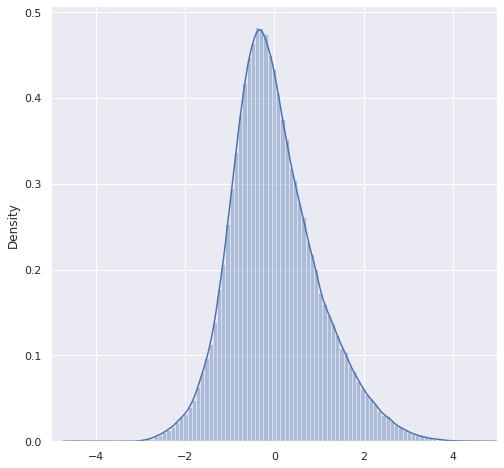

In [65]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim([-5,5])
sns.distplot(result.resid,bins=100);

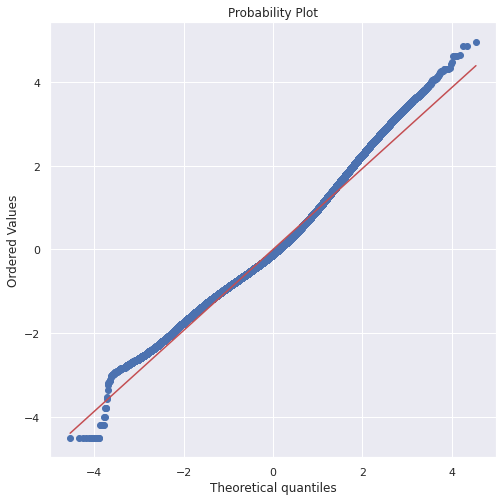

In [66]:
fig, ax = plt.subplots(figsize=(8,8))
stats.probplot(result.resid, plot=plt);

Analizing perfomance (metrics)

In [11]:
N = Xtrain.shape[0]
# using statsmodel
prediction = result.predict(sm.add_constant(Xtrain))
mean_square_error_sk = mean_squared_error(Ytrain, prediction)
print(mean_square_error_sk)

0.6567162033351276


In [12]:
norm_mse_sk = 1-r2_score(Ytrain,prediction)
print(norm_mse_sk)

R_squared_sk = r2_score(Ytrain,prediction) 
print(R_squared_sk)

0.6914753380412028
0.30852466195879724


In [13]:
predTest = result.predict(sm.add_constant(Xtest))
mean_square_error_sk = mean_squared_error(Ytest, predTest)
print(mean_square_error_sk)

0.7200904330814724


El MSE es identico!

## SECTION 5: Regularized Linear Regression: Ridge and Lasso

First we look for the $lambda$ that fits better out model

In [17]:
ridge_cv = RidgeCV(alphas=lambdas,cv=5)
ridge_cv.fit(Xtrain,Ytrain)

print('Best lambda:', ridge_cv.alpha_, 'R2 score:', ridge_cv.best_score_)

Best lambda: 1.0 R2 score: 0.30811127312672076


In [18]:
lasso_cv =LassoCV(alphas=lambdas,cv=5)
lasso_cv.fit(Xtrain,Ytrain)

lasso_r2 =  np.mean(cross_val_score(lasso_cv, Xtrain,Ytrain))

print('Best lambda:', lasso_cv.alpha_, 'R2 score:',lasso_r2)

Best lambda: 1e-05 R2 score: 0.30810897448325975


## Undertanding the model

In [19]:
weights = pd.DataFrame({'lr':lr.coef_, 'ridge_cv':ridge_cv.coef_, 'lasso_cv':lasso_cv.coef_},index=Xtrain.columns)
weights.T

,Rating,Released,LinearizedRating,LinearizedPrice,LogSize,LogLast Updated,CategoryPuzzle,CategoryEducation,CategoryTools,CategoryEntertainment,...,Content RatingEveryone 10+,Content RatingTeen,Content RatingAdults only 18+,Content RatingUnrated,Ad SupportedTrue,Ad SupportedFalse,In App PurchasesTrue,In App PurchasesFalse,Editors ChoiceFalse,Editors ChoiceTrue
lr,0.874,0.385,-0.728,-0.040,0.036,-0.260,-0.067,-0.182,0.079,0.045,...,0.050,0.022,0.035,-0.021,0.201,-0.201,0.196,-0.196,-0.649,0.649
ridge_cv,0.906,0.385,-0.750,-0.039,0.035,-0.259,-0.068,-0.184,0.075,0.039,...,0.157,0.132,0.212,-0.636,0.200,-0.200,0.194,-0.194,-0.795,0.795
lasso_cv,0.905,0.385,-0.750,-0.040,0.035,-0.259,-0.041,-0.158,0.101,0.065,...,0.025,0.000,0.000,-0.000,0.401,-0.000,0.389,-0.000,-1.584,0.000


<Axes: >

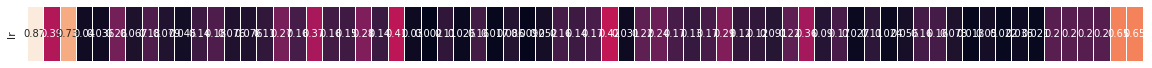

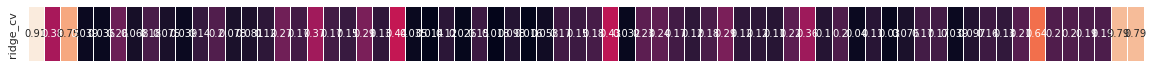

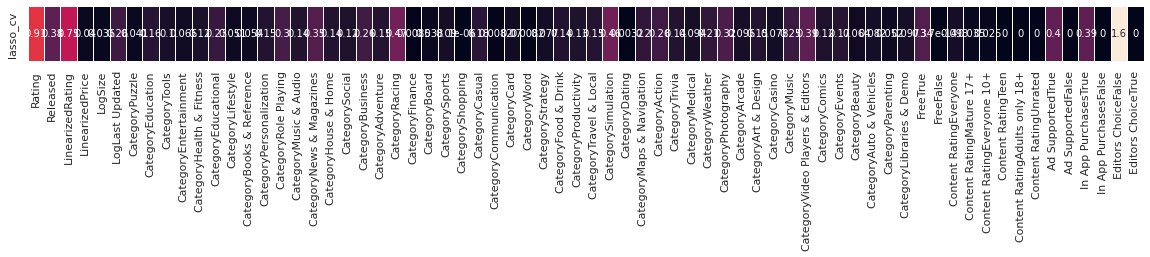

In [20]:
fig,  ax = plt.subplots( figsize = (20,1))
sns.heatmap(weights.T.loc[['lr'],:].abs(),annot=True, linewidths=.5,ax=ax,cbar=False,xticklabels=False)

plt.figure(figsize = (20,1))
sns.heatmap(weights.T.loc[['ridge_cv'],:].abs(),annot=True, linewidths=.5,cbar=False,xticklabels=False)

plt.figure(figsize = (20,1))
sns.heatmap(weights.T.loc[['lasso_cv'],:].abs(),annot=True, linewidths=.5,cbar=False,xticklabels=True)

<Axes: >

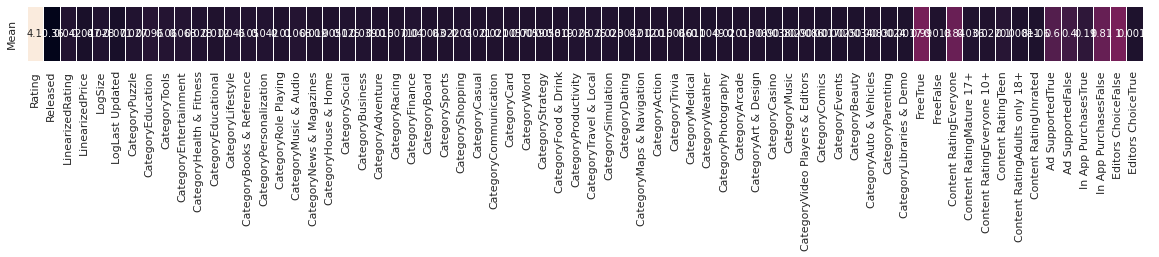

In [22]:
plt.figure(figsize = (20,1))
sns.heatmap(Xtrain.mean().to_frame().T.rename(index={0:'Mean'}),annot=True, linewidths=.5,cbar=False,xticklabels=True)

We can notice that the are no clear patterns between different models, the ridge and linear regression might be the closest ones but there is still no clear patterns. We will try to scale the data, altough the real reason is the little correlation.

In [24]:
def scaling_preprocessing(X, y, scaler=None):
    print('Original shape:{}'.format(X.shape))
    categorical_columns = X.dtypes[X.dtypes == 'category'].index.values
    
    # We scale the numerical columns
    numerical_columns = [c for c in X.columns if c not in categorical_columns]
    if scaler is None: 
        # We only want the scaler to fit the train data
        scaler = MinMaxScaler()
        X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

    return X, y, scaler

Xtrain, Ytrain, scaler = scaling_preprocessing(Xtrain,Ytrain)

Original shape:(249862, 68)


<Axes: >

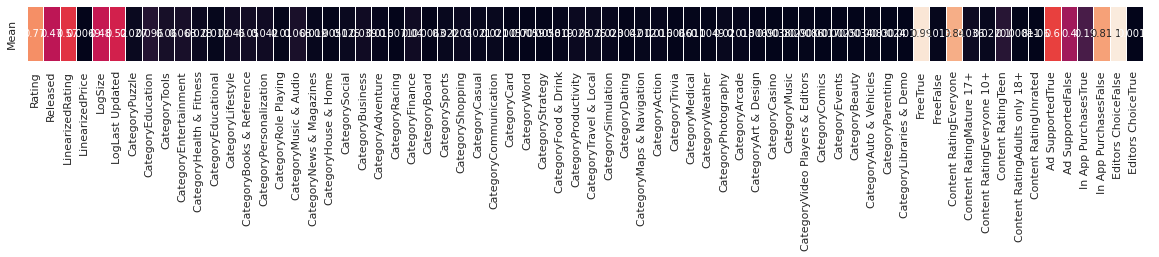

In [25]:
plt.figure(figsize = (20,1))
sns.heatmap(Xtrain.mean().to_frame().T.rename(index={0:'Mean'}),annot=True, linewidths=.5,cbar=False,xticklabels=True)

In [28]:
lr_scaled = LinearRegression()
lr_scaled.fit(Xtrain,Ytrain)
r2_lr_scaled = np.mean(cross_val_score(lr_scaled, Xtrain,Ytrain, cv=5, scoring='r2'))

ridge_cv_scaled =RidgeCV(alphas=lambdas,cv=5)
ridge_cv_scaled.fit(Xtrain,Ytrain)
r2_ridge_scaled = np.mean(cross_val_score(ridge_cv_scaled, Xtrain,Ytrain, cv=5, scoring='r2'))


lasso_cv_scaled =LassoCV(alphas=lambdas,cv=5)
lasso_cv_scaled.fit(Xtrain,Ytrain)
r2_lasso_scaled = np.mean(cross_val_score(ridge_cv_scaled, Xtrain,Ytrain, cv=5, scoring='r2'))

weights = pd.DataFrame({'lr scaled':lr_scaled.coef_, 'ridge_cv scaled':ridge_cv_scaled.coef_, 'lasso_cv scaled':lasso_cv_scaled.coef_},index=Xtrain.columns)
weights.T

,Rating,Released,LinearizedRating,LinearizedPrice,LogSize,LogLast Updated,CategoryPuzzle,CategoryEducation,CategoryTools,CategoryEntertainment,...,Content RatingEveryone 10+,Content RatingTeen,Content RatingAdults only 18+,Content RatingUnrated,Ad SupportedTrue,Ad SupportedFalse,In App PurchasesTrue,In App PurchasesFalse,Editors ChoiceFalse,Editors ChoiceTrue
lr scaled,3.624,0.98,-3.399,-0.499,0.208,-1.34,1.918e+10,1.918e+10,1.918e+10,1.918e+10,...,-5.962e+10,-5.962e+10,-5.962e+10,-5.962e+10,-3.435e+11,-3.435e+11,7.694e+10,7.694e+10,-6.454e+09,-6.454e+09
ridge_cv scaled,3.606,0.98,-3.386,-0.495,0.208,-1.34,-6.798e-02,-1.844e-01,7.455e-02,3.934e-02,...,1.565e-01,1.317e-01,2.125e-01,-6.364e-01,2.006e-01,-2.006e-01,1.943e-01,-1.943e-01,-7.945e-01,7.945e-01
lasso_cv scaled,3.612,0.98,-3.391,-0.487,0.207,-1.34,-4.139e-02,-1.580e-01,1.007e-01,6.548e-02,...,2.475e-02,0.000e+00,0.000e+00,-0.000e+00,4.014e-01,-0.000e+00,3.887e-01,-0.000e+00,-1.584e+00,0.000e+00


Let's try from scratch but using one hot encoding for categorical variables intead of binary variables

In [30]:
datasetTrain = pd.read_csv('../Dades/X_train_modified.csv')
datasetTest  = pd.read_csv('../Dades/X_test_modified.csv')

columsToDrop = ['Maximum Installs', 'Price', 'Size', 'Download', 'Last Updated', 'Installs', 'LogInstalls']
categoricalColumns = ['Category', 'Free', 'Content Rating', 'Ad Supported', 'In App Purchases', 'Editors Choice']

# Convert to categorical variables
for column in categoricalColumns:
    datasetTrain[column] = datasetTrain[column].astype('category')
    datasetTest[column] = datasetTest[column].astype('category')

# Drop repeated or unwanted data (Installs is the catageorial version of "Maximum installs")
datasetTrain = datasetTrain.drop(columns=columsToDrop)
datasetTest  = datasetTest.drop(columns=columsToDrop)
    

Category              category
Rating                 float64
Free                  category
Released               float64
Content Rating        category
Ad Supported          category
In App Purchases      category
Editors Choice        category
LogMaximumInstalls     float64
LinearizedRating       float64
LinearizedPrice        float64
LogSize                float64
LogLast Updated        float64
dtype: object

In [43]:
Xtrain = datasetTrain.loc[:, datasetTrain.columns != 'LogMaximumInstalls']
Ytrain = datasetTrain['LogMaximumInstalls']

Xtest = datasetTest.loc[:, datasetTest.columns != 'LogMaximumInstalls']
Ytest = datasetTest['LogMaximumInstalls']



Category              category
Rating                 float64
Free                  category
Released               float64
Content Rating        category
Ad Supported          category
In App Purchases      category
Editors Choice        category
LogMaximumInstalls     float64
LinearizedRating       float64
LinearizedPrice        float64
LogSize                float64
LogLast Updated        float64
dtype: object

In [46]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def categorical_preprocessing(X, y, preprocessor=None):
    print('Original shape:{}'.format(X.shape))
    
    # Identify categorical and numerical columns
    categorical_columns = X.select_dtypes(include=['category', 'object']).columns.tolist()
    numerical_columns = X.select_dtypes(include=['number']).columns.tolist()
    
    if preprocessor is None:
        # Define the preprocessing pipeline
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', MinMaxScaler(), numerical_columns),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
            ]
        )
        
        # Fit the preprocessor on the training data
        X = preprocessor.fit_transform(X)
    else:
        # Transform the test data using the pre-fitted preprocessor
        X = preprocessor.transform(X)
    
    return X, y, preprocessor


Xtrain, Ytrain, preprocessor = categorical_preprocessing(Xtrain,Ytrain)
Xtest, Ytest, _ = categorical_preprocessing(Xtest,Ytest,preprocessor)

Original shape:(249862, 12)
Original shape:(123320, 12)


In [47]:
lr_one_hot = LinearRegression()
lr_one_hot.fit(Xtrain,Ytrain)

r2_lr_one_hot_train = lr_one_hot.score(Xtrain,Ytrain)
r2_lr_one_hot_cv = np.mean(cross_val_score(lr_one_hot, Xtrain,Ytrain, cv=5, scoring='r2'))

print('Train R2 score: {}\nCross-Validation R2 score: {}'.format(r2_lr_one_hot_train, r2_lr_one_hot_cv))

Train R2 score: 0.3085351920881503
Cross-Validation R2 score: 0.30810785454205686


Yet the R2 score is the same as in the first try, 30%, which is basically what you get from random